# COVID-19 Global Analysis with BigQuery and Python

## 📋 Project Objective
In this project, we perform an end-to-end analysis of global COVID-19 data.  
We use SQL queries on Google's BigQuery public dataset to extract case trends, detect anomalies, cluster countries based on severity, and create powerful visualizations using Python.

**Tools Used:**  
BigQuery, Pandas, Matplotlib, Plotly, Scikit-Learn (KMeans)

---

In [2]:
from google.colab import auth
auth.authenticate_user()

In [3]:
from google.cloud import bigquery
project_id = 'analytics-project-458010'
client = bigquery.Client(project = project_id)

Top 10 Country with COVID **Cases**

In [9]:
query = """
SELECT
    country_name,
    SUM(new_confirmed) AS total_cases
FROM
    `bigquery-public-data.covid19_open_data.covid19_open_data`
WHERE
    date BETWEEN '2020-01-01' AND '2023-12-31'
GROUP BY
    country_name
ORDER BY
    total_cases DESC
LIMIT 10
"""

# Run query
query_job = client.query(query)

# Convert results to Pandas DataFrame
df = query_job.to_dataframe()

# Show results
df.head()


,country_name,total_cases
0,United States of America,272181074
1,India,126463452
2,Brazil,109948210
3,United Kingdom,93262911
4,France,90395908


Top 10 Country with Most COVID **Deaths**

In [10]:
query = """
SELECT
  country_name,
  SUM(new_deceased) AS total_deaths
FROM
    `bigquery-public-data.covid19_open_data.covid19_open_data`
WHERE
    date BETWEEN '2020-01-01' AND '2023-12-31'
GROUP BY
    country_name
ORDER BY
    total_deaths DESC
LIMIT 10
"""

# Run query
query_job = client.query(query)

# Convert results to Pandas DataFrame
df = query_job.to_dataframe()

# Show results
df.head()

,country_name,total_deaths
0,United States of America,3054446
1,Brazil,2220286
2,India,1501682
3,Russia,706791
4,Peru,625820


**Monthly** Global Case Trends

In [13]:
query = """
SELECT
  EXTRACT(YEAR FROM date) AS year,
  EXTRACT(MONTH FROM date) AS month,
  SUM(new_confirmed) AS monthly_cases
FROM
  `bigquery-public-data.covid19_open_data.covid19_open_data`
GROUP BY
  year, month
ORDER BY
  year, month
"""
df_monthly_trends = client.query(query).to_dataframe()
df_monthly_trends.head(20)


,year,month,monthly_cases
0,2020,1,54666
1,2020,2,-141599
2,2020,3,2195224
3,2020,4,5900566
4,2020,5,6952994
5,2020,6,10523353
6,2020,7,18846966
7,2020,8,21267674
8,2020,9,22948407
9,2020,10,32110862


Highest Death Rate per **Country**

In [22]:
query = """
SELECT
  country_name,
  SUM(new_confirmed) AS total_cases,
  SUM(new_deceased) AS total_deaths
FROM
  `bigquery-public-data.covid19_open_data.covid19_open_data`
WHERE
  date BETWEEN '2020-01-01' AND '2023-12-31'
GROUP BY
  country_name
HAVING
  SUM(new_confirmed) > 10000
"""
df_death_rate = client.query(query).to_dataframe()
df_death_rate['death_rate %'] = ((df_death_rate['total_deaths'] / df_death_rate['total_cases']) * 100).round(2)
df_death_rate_sorted = df_death_rate.sort_values(by='death_rate %', ascending=False)
df_death_rate_sorted.head(10)

,country_name,total_cases,total_deaths,death_rate %
117,Yemen,11932,2155,18.06
137,Sudan,76591,4961,6.48
46,Peru,10651933,625820,5.88
72,Syria,57197,3163,5.53
50,Somalia,27197,1361,5.0
184,Egypt,515348,24796,4.81
178,Afghanistan,352280,14432,4.1
13,Bosnia and Herzegovina,397602,16104,4.05
126,Ecuador,999837,35884,3.59
130,Myanmar,617739,19444,3.15


**First** Reported Case per **Country**

In [16]:
query = """
WITH ranked_cases AS (
  SELECT
    country_name,
    date,
    ROW_NUMBER() OVER (PARTITION BY country_name ORDER BY date ASC) AS rn
  FROM
    `bigquery-public-data.covid19_open_data.covid19_open_data`
  WHERE
    new_confirmed > 0
)
SELECT
  country_name,
  date AS first_case_date
FROM
  ranked_cases
WHERE
  rn = 1
ORDER BY
  first_case_date;
"""
df_first_case = client.query(query).to_dataframe()
df_first_case.head()


,country_name,first_case_date
0,Spain,2020-01-01
1,Argentina,2020-01-01
2,Brazil,2020-01-01
3,Mali,2020-01-02
4,Rwanda,2020-01-02


**Highest** Peak Daily New Cases for Each **Country**

In [21]:
query = """
WITH country_daily_cases AS (
  SELECT
    country_name,
    date,
    SUM(new_confirmed) AS daily_cases
  FROM
    `bigquery-public-data.covid19_open_data.covid19_open_data`
  GROUP BY
    country_name, date
)
SELECT
  country_name,
  date,
  daily_cases
FROM (
  SELECT
    country_name,
    date,
    daily_cases,
    ROW_NUMBER() OVER (PARTITION BY country_name ORDER BY daily_cases DESC) AS rn
  FROM country_daily_cases
) ranked
WHERE rn = 1;
"""
df_peak_cases = client.query(query).to_dataframe()
df_peak_cases_sorted = df_peak_cases.sort_values(by='daily_cases', ascending=False)
df_peak_cases_sorted.head(10)


,country_name,date,daily_cases
74,Netherlands,2022-06-07,23239812
233,India,2022-07-17,4725563
168,United States of America,2022-01-10,3996107
110,Romania,2021-12-31,1788699
117,France,2022-01-25,1255707
173,United Kingdom,2022-01-04,1088149
195,Brazil,2022-02-03,940435
42,Germany,2022-02-08,740233
54,Italy,2022-07-08,726378
48,South Korea,2022-03-15,621328


Compare **Top 3** Countries' **Monthly** Cases

In [24]:
# Define the SQL query
query_top3_monthly = """
WITH top_countries AS (
  SELECT
    country_name
  FROM
    `bigquery-public-data.covid19_open_data.covid19_open_data`
  WHERE
    date BETWEEN '2020-01-01' AND '2023-12-31'
  GROUP BY
    country_name
  ORDER BY
    SUM(new_confirmed) DESC
  LIMIT 3
)

SELECT
  main.country_name,
  EXTRACT(YEAR FROM main.date) AS year,
  EXTRACT(MONTH FROM main.date) AS month,
  SUM(main.new_confirmed) AS monthly_cases
FROM
  `bigquery-public-data.covid19_open_data.covid19_open_data` AS main
JOIN
  top_countries AS top
ON
  main.country_name = top.country_name
WHERE
  main.date BETWEEN '2020-01-01' AND '2023-12-31'
GROUP BY
  main.country_name, year, month
ORDER BY
  year, month, main.country_name
"""

df_top3_monthly = client.query(query_top3_monthly).to_dataframe()
df_top3_monthly.head()

# Pivot to make months as index, countries as columns
df_pivot = df_top3_monthly.pivot(index=['year', 'month'], columns='country_name', values='monthly_cases')
df_pivot.head()


country_name   Brazil   India  United States of America
year month                                             
2020 1          30364       2                        23
     2           9693       5                       202
     3          48096    3537                    627036
     4         286554   74654                   2618323
     5        1437195  439856                   2176567

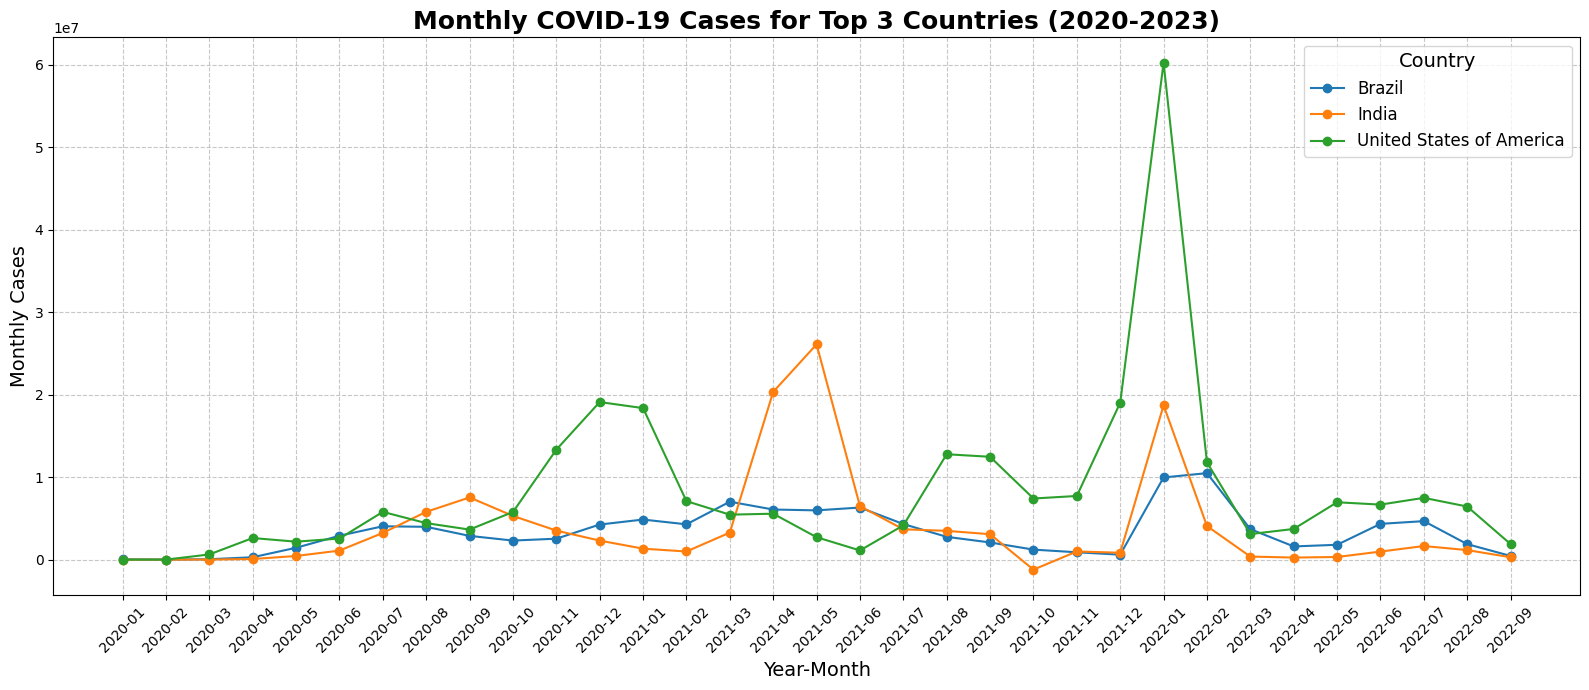

In [44]:
import matplotlib.pyplot as plt

# 1. Make a Year-Month column instead of tuple
df_top3_monthly['year_month'] = df_top3_monthly.apply(lambda row: f"{int(row['year'])}-{int(row['month']):02}", axis=1)
df_pivot = df_top3_monthly.pivot(index='year_month', columns='country_name', values='monthly_cases')
df_pivot = df_pivot.sort_index()

# 4. Plot
plt.figure(figsize=(16, 7))

for country in df_pivot.columns:
    plt.plot(df_pivot.index, df_pivot[country], marker='o', label=country)

plt.title('Monthly COVID-19 Cases for Top 3 Countries (2020-2023)', fontsize=18, fontweight='bold')
plt.xlabel('Year-Month', fontsize=14)
plt.ylabel('Monthly Cases', fontsize=14)

plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)

plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(title='Country', fontsize=12, title_fontsize=14)

plt.tight_layout()
plt.show()


In [15]:
query_daily_rate = '''
SELECT
  country_name,
  date,
  daily_cases,
  LAG(daily_cases) OVER (PARTITION BY country_name ORDER BY date) AS prev_day_cases,
  COALESCE(daily_cases - LAG(daily_cases) OVER (PARTITION BY country_name ORDER BY date), 0) AS case_diff
FROM (
  -- Subquery: Aggregate to remove duplicates (1 row per country per day)
  SELECT
    country_name,
    date,
    SUM(new_confirmed) AS daily_cases
  FROM
    `bigquery-public-data.covid19_open_data.covid19_open_data`
  WHERE
    date BETWEEN '2021-05-01' AND '2022-05-01'
    AND country_name IS NOT NULL  -- Exclude rows with missing country
  GROUP BY
    country_name, date
)
ORDER BY
  country_name, date
'''
df_daily_rate = client.query(query_daily_rate).to_dataframe()
df_daily_USA = df_daily_rate[df_daily_rate['country_name'] == 'United States of America']
df_daily_USA.head(50)


,country_name,date,daily_cases,prev_day_cases,case_diff
85644,United States of America,2021-05-01,136165,<NA>,0
85645,United States of America,2021-05-02,95089,136165,-41076
85646,United States of America,2021-05-03,132722,95089,37633
85647,United States of America,2021-05-04,125269,132722,-7453
85648,United States of America,2021-05-05,136570,125269,11301
85649,United States of America,2021-05-06,137781,136570,1211
85650,United States of America,2021-05-07,138827,137781,1046
85651,United States of America,2021-05-08,102998,138827,-35829
85652,United States of America,2021-05-09,70640,102998,-32358
85653,United States of America,2021-05-10,97106,70640,26466


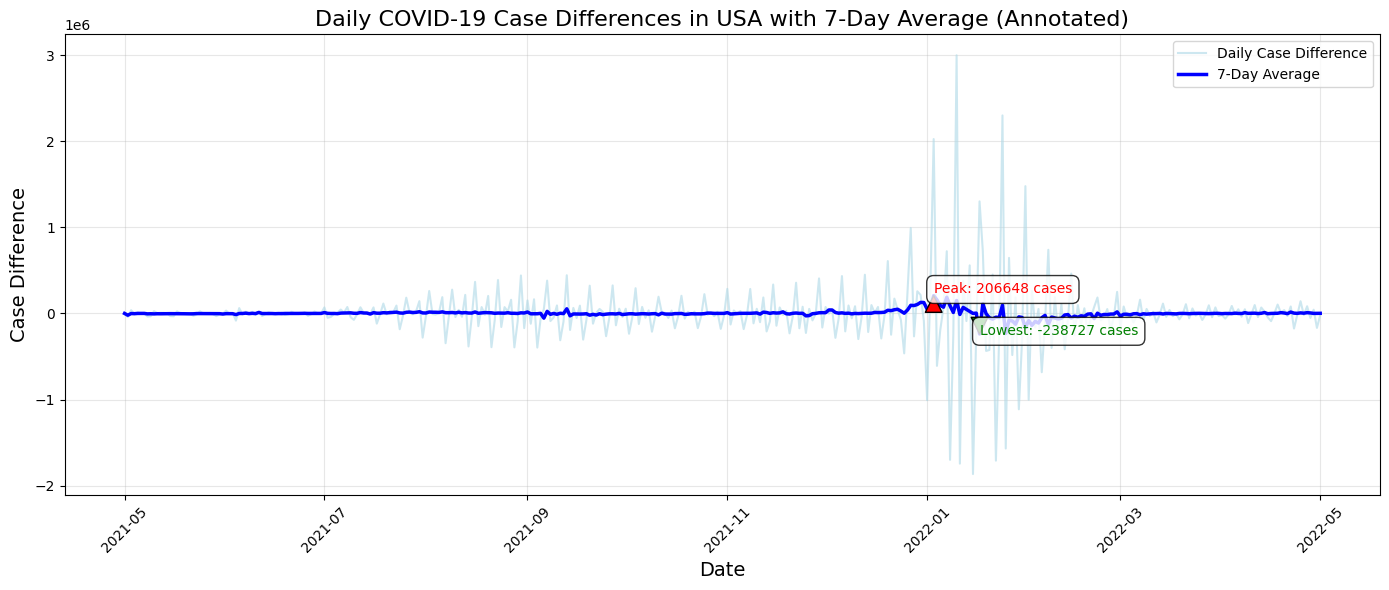

In [35]:
import matplotlib.pyplot as plt
import pandas as pd

df_plot = df_daily_USA.copy()

# Calculate 7-day rolling average
df_plot['case_diff_7d_avg'] = df_plot['case_diff'].rolling(window=7, min_periods=1).mean()

# Find Peak and Dip
peak_point = df_plot.loc[df_plot['case_diff_7d_avg'].idxmax()]
low_point = df_plot.loc[df_plot['case_diff_7d_avg'].idxmin()]

# Create figure
plt.figure(figsize=(14, 6))

# Plot raw daily differences
plt.plot(
    df_plot['date'],
    df_plot['case_diff'],
    color='lightblue',
    alpha=0.6,
    label='Daily Case Difference'
)

# Plot 7-day average
plt.plot(
    df_plot['date'],
    df_plot['case_diff_7d_avg'],
    color='blue',
    linewidth=2.5,
    label='7-Day Average'
)

# Annotate Peak
plt.annotate(
    f"Peak: {int(peak_point['case_diff_7d_avg'])} cases",
    xy=(peak_point['date'], peak_point['case_diff_7d_avg']),
    xytext=(peak_point['date'], peak_point['case_diff_7d_avg'] + 25000),
    arrowprops=dict(facecolor='red', shrink=0.01),
    fontsize=10,
    color='red',
    bbox=dict(boxstyle='round,pad=0.5', fc='white', alpha=0.8)
)

# Annotate Dip
plt.annotate(
    f"Lowest: {int(low_point['case_diff_7d_avg'])} cases",
    xy=(low_point['date'], low_point['case_diff_7d_avg']),
    xytext=(low_point['date'], low_point['case_diff_7d_avg'] - 15000),
    arrowprops=dict(facecolor='green', shrink=0.01),
    fontsize=10,
    color='green',
    bbox=dict(boxstyle='round,pad=0.5', fc='white', alpha=0.8)
)

# Customize plot
plt.title('Daily COVID-19 Case Differences in USA with 7-Day Average (Annotated)', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Case Difference', fontsize=14)
plt.xticks(rotation=45)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()

# Show plot
plt.show()

In [52]:
# Load World Map Data
query_world_map = """
SELECT
  country_name,
  SUM(new_confirmed) AS total_cases
FROM
  `bigquery-public-data.covid19_open_data.covid19_open_data`
WHERE
  date BETWEEN '2020-01-01' AND '2023-12-31'
  AND country_name IS NOT NULL
GROUP BY
  country_name
ORDER BY
  total_cases DESC
 """
df_world_map = client.query(query_world_map).to_dataframe()

# Now ready for plotly world map!
import plotly.express as px

fig = px.choropleth(
    df_world_map,
    locations="country_name",
    locationmode="country names",
    color="total_cases",
    color_continuous_scale="Viridis",
    range_color=[0, df_world_map['total_cases'].quantile(0.95)],  # Focus on 95% of data
    hover_name="country_name",
    hover_data={"total_cases": ":,"},
    title="<b>Global COVID-19 Cases (2020-2023)</b>",
    labels={'total_cases': 'Total Cases'},
    projection="natural earth"
)

fig.update_layout(
    coloraxis_colorbar=dict(
        title="Cases",
        tickformat=",",
    ),
    hoverlabel=dict(
        bgcolor="white",
        font_size=12
    )
)

fig.show()


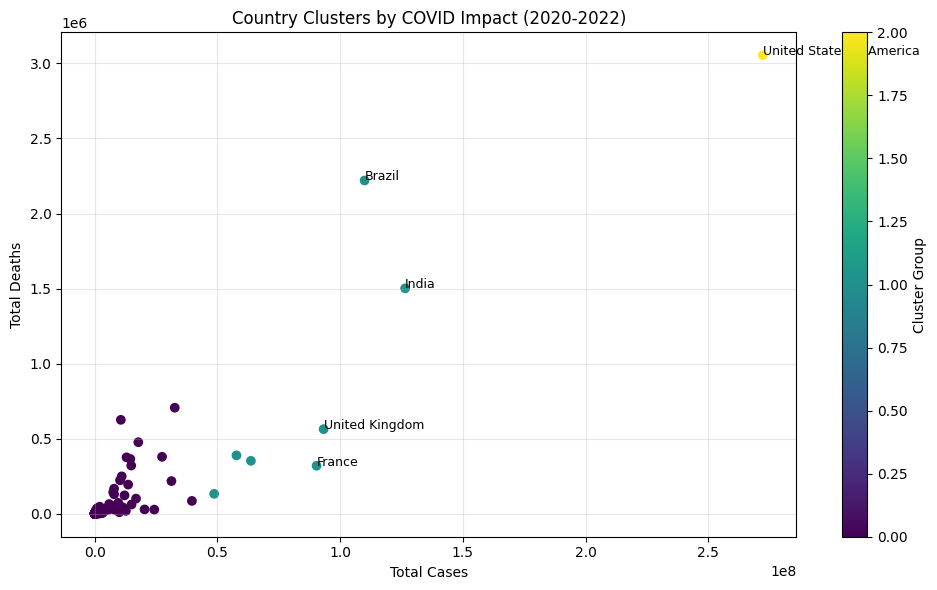


Cluster Summary:
cluster
0    195
1      7
2      1
Name: country_name, dtype: int64

Top Countries in Each Cluster:

Cluster 0:
    country_name  total_cases  total_deaths
117        Japan     39621765         85733
25        Russia     32627601        706791
30         Spain     31279968        217985

Cluster 1:
       country_name  total_cases  total_deaths
31            India    126463452       1501682
157          Brazil    109948210       2220286
165  United Kingdom     93262911        563933

Cluster 2:
                country_name  total_cases  total_deaths
85  United States of America    272181074       3054446


,country_name,total_cases,total_deaths,cluster
0,Chile,13636490,194597,0
1,Djibouti,15690,189,0
2,Faroe Islands,34658,28,0
3,Guernsey,30992,62,0
4,Indonesia,14524997,364925,0


In [58]:
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# 1. Load the data
query = """
SELECT
  country_name,
  SUM(new_confirmed) AS total_cases,
  SUM(new_deceased) AS total_deaths
FROM
  `bigquery-public-data.covid19_open_data.covid19_open_data`
WHERE
  date BETWEEN '2020-01-01' AND '2022-12-31'
  AND country_name IS NOT NULL
GROUP BY
  country_name
HAVING
  SUM(new_confirmed) > 10000
"""
df = client.query(query).to_dataframe()

# 2. Simple clustering
kmeans = KMeans(n_clusters=3, random_state=42)
df['cluster'] = kmeans.fit_predict(df[['total_cases', 'total_deaths']])

# 3. Basic visualization
plt.figure(figsize=(10, 6))
plt.scatter(df['total_cases'], df['total_deaths'], c=df['cluster'], cmap='viridis')

# Add labels for some countries
for _, row in df.nlargest(5, 'total_cases').iterrows():
    plt.text(row['total_cases'], row['total_deaths'], row['country_name'], fontsize=9)

plt.xlabel('Total Cases')
plt.ylabel('Total Deaths')
plt.title('Country Clusters by COVID Impact (2020-2022)')
plt.colorbar(label='Cluster Group')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 4. Show cluster info
print("\nCluster Summary:")
print(df.groupby('cluster')['country_name'].count())

print("\nTop Countries in Each Cluster:")
for cluster_num in sorted(df['cluster'].unique()):
    print(f"\nCluster {cluster_num}:")
    print(df[df['cluster'] == cluster_num].nlargest(3, 'total_cases')[['country_name', 'total_cases', 'total_deaths']])


In [59]:
# Load anomaly data
query_anomaly = """
SELECT
  country_name,
  date,
  daily_cases,
  LAG(daily_cases) OVER (PARTITION BY country_name ORDER BY date) AS prev_day_cases,
  COALESCE(daily_cases - LAG(daily_cases) OVER (PARTITION BY country_name ORDER BY date), 0) AS case_diff
FROM (
  -- Subquery: Aggregate to remove duplicates (1 row per country per day)
  SELECT
    country_name,
    date,
    SUM(new_confirmed) AS daily_cases
  FROM
    `bigquery-public-data.covid19_open_data.covid19_open_data`
  WHERE
    date BETWEEN '2021-05-01' AND '2022-05-01'
    AND country_name IS NOT NULL
  GROUP BY
    country_name, date
)
ORDER BY
  country_name, date
 """
df_anomaly = client.query(query_anomaly).to_dataframe()

# Calculate Z-Score
from scipy import stats
import numpy as np

def detect_anomalies(group):
    group['z_score'] = np.abs(stats.zscore(group['case_diff'].fillna(0)))
    return group

df_anomaly = df_anomaly.groupby('country_name').apply(detect_anomalies)

# Set threshold and get anomalies
anomalies = df_anomaly[df_anomaly['z_score'] > 3]

# Show top anomalies
anomalies[['country_name', 'date', 'daily_cases', 'case_diff', 'z_score']].sort_values('z_score', ascending=False)


<ipython-input-59-57714ebdb794>:36: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



,,country_name,date,daily_cases,case_diff,z_score
country_name,,,,,,
Haiti,34173,Haiti,2021-09-13,-9992,-20004,15.567885
Hong Kong,35416,Hong Kong,2022-02-05,356,225,15.322774
Macau,46633,Macau,2021-09-29,4,3,14.833754
Australia,4735,Australia,2022-04-09,547782,876828,13.795215
Mozambique,54452,Mozambique,2022-02-09,9899,19526,13.642882
...,...,...,...,...,...,...
Hungary,35698,Hungary,2021-11-13,21060,21060,3.005999
Armenia,3946,Armenia,2022-02-11,1574,-828,3.001413
Martinique,50058,Martinique,2022-02-07,3134,3134,3.001383


# 📈 Conclusion & Insights

Through this project, we explored global COVID-19 patterns over 2020–2023.

**Key Insights:**
- **Major Surges:** The United States experienced major anomaly spikes during late 2021 corresponding to the Delta and Omicron waves.
- **Global Spread:** Highest cases were found in USA, India, and Brazil based on total confirmed cases.
- **Country Clustering:** Clustering countries based on total cases and deaths revealed distinct groups: high-risk vs low-risk countries.
- **Data-driven Strategies:** Anomaly detection and clustering approaches help policymakers better allocate healthcare resources during future outbreaks.

---

# ✅ Final Thoughts

Further extensions could include:
- Forecasting future outbreaks
- Adding vaccination and hospitalization data
- Building real-time dashboards using Streamlit

---
